In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import mmcv
import cv2
from collections import Counter
import numpy as np
import lap

#### OCR

In [2]:
ocr = json.load(open('/home/ubuntu/oljike/data/videos1/ocr_results/results/ocr_with_gameclockrunning/2020_01-20_NCState_at_Virginia/2020_01-20_NCState_at_Virginia_ocr.json'))

In [3]:
l = None
cnt = 0
for k, v in ocr['results'].items():
    if ocr['results'][k]['score_bug_present'] and ocr['results'][k]['game_clock_running']:
        cnt+=1
        l = k
print(cnt, len(ocr['results']), l)

58673 79123 78514


### Players Stats Main

In [4]:
# csv_path = './demos/custom_5vals_colors_all_30ep_debug/2021_01_20_Colorado_at_Washington_orig.csv'
# tracking_path = './demos/custom_5vals_colors_all_30ep_debug/2021_01_20_Colorado_at_Washington_orig.json'

csv_path = './demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.csv'
tracking_path = './demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.json'
player_time = './demos/custom_5vals_colors_all_30ep_debug/player_time.csv'
pl_time = pd.read_csv(player_time)

In [5]:
def get_players(path):

    players = pd.read_csv(path)
    
    teams = players['market'].unique()
    
    players1 = players.loc[players['market'] == teams[0]]['jersey_number'].tolist()
    players1 = set([str(x) for x in players1])

    players2 = players.loc[players['market'] == teams[1]]['jersey_number'].tolist()
    players2 = set([str(x) for x in players2])
    
    teams_dct = []
    teams_dct.append((players1, 0))
    teams_dct.append((players2, 1))
    
    
    return players1, players2, teams, teams_dct
players1, players2, teams, teams_dct  = get_players(csv_path)

### Read jersey tracking info

In [6]:
tracking = json.load(open(tracking_path))
print("Number of active frames ", len(tracking), )

Number of active frames  58792


In [7]:
def get_cnt(tracking):

    team_1 = []
    team_2 = []
    cnt = 0
    for k, v in tracking.items():
        for el in v:
            curr_el = el.split(',')
            if curr_el[-2] == '0.0':
                team_1.append(curr_el[-1])
            elif curr_el[-2] == '1.0':
                team_2.append(curr_el[-1])
            cnt += 1
        
    print("Team balance {} / {}".format(len(team_1), len(team_2)))
    cnt_1 = Counter(team_1)
    cnt_2 = Counter(team_2)
    
    return cnt_1, cnt_2
cnt_1, cnt_2 = get_cnt(tracking)

Team balance 255863 / 280779


#### Remove non-existing jersey numbers


In [8]:
def remove_nonex(cnt, players1, players2):
    
    for k in list(cnt):
        if k=='None': 
            cnt.pop(k, 'None')
        elif k not in players1 and k not in players2:
            cnt.pop(k, 'None')

    return cnt

cnt_1 = remove_nonex(cnt_1, players1, players2)
cnt_2 = remove_nonex(cnt_2, players1, players2)

#### Calculate Histogram Loss

In [9]:
def calc_hist_loss(cnt, players1, players2):
    
    max_ = max(list(cnt.values()))
    min_ = min(list(cnt.values()))
    loss_1 = 0
    loss_2 = 0
    for k, v in cnt.items():

        curr_val = (int(v) - min_)/(max_ - min_)       
        if k in players1 and k in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1 - curr_val           
        elif (k) in players1 and (k) not in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1
        elif (k) not in players1 and (k) in players2:
            loss_1 += 1
            loss_2 += 1 - curr_val
        elif (k) not in players1 and (k) not in players2:
            loss_1 += 1
            loss_2 += 1
            
    return loss_1, loss_2

In [10]:
cnt1_l1, cnt1_l2 = calc_hist_loss(cnt_1, players1, players2)
cnt2_l1, cnt2_l2 = calc_hist_loss(cnt_2, players1, players2)

In [11]:
def get_cost(cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2):

    cost_matrix = np.array([[cnt1_l1, cnt1_l2], [cnt2_l1, cnt2_l2]])
    print(cost_matrix)
    matches, unmatched_a, unmatched_b = [], [], []
    cost, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    for ix, mx in enumerate(x):
        if mx >= 0:
            matches.append([ix, mx])
    unmatched_a = np.where(x < 0)[0]
    unmatched_b = np.where(y < 0)[0]
    matches = np.asarray(matches)
    
    if matches[0][1] == 0:
        pair1 = (cnt_1, players1)
        pair2 = (cnt_2, players2)
    elif matches[0][1] == 1:
        pair1 = (cnt_1, players2)
        pair2 = (cnt_2, players1)
        
    return pair1, pair2

pair1, pair2 = get_cost(cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2)

[[12.16722614  9.48239529]
 [ 5.63856484  7.77328463]]


### Calculate stats for each player

In [12]:
def get_stats(cnt, players, length=len(tracking)):   
    res = {}
    for k, v in cnt.items():
        if k in players:
#             res[k] = str(round(100 * (v / length), 2)) + '%'  
            res[k] = str(round(v / 25 / 60, 2)) + 'min'  
            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

print(str(teams[0]), get_stats(pair1[0], pair1[1]))
print(str(teams[1]), get_stats(pair2[0], pair2[1]))

North Carolina State {'0': '35.75min', '13': '27.18min', '2': '25.8min', '25': '24.89min', '23': '22.61min', '12': '2.4min', '30': '11.54min', '53': '10.69min', '22': '0.69min'}
Virginia {'11': '54.03min', '21': '4.54min', '0': '38.46min', '13': '27.69min', '10': '20.54min', '24': '18.94min', '4': '18.76min'}


In [18]:
def get_stats_minutes(cnt, players, pl_time, teams, ocr):   
        
    if players in teams[0]:
        idx = teams[0][1]
    else:
        idx = teams[1][1]
    
    teams = pl_time['team'].unique()
    time_info = pl_time.loc[pl_time['team'] == teams[idx]][['minutes_int', 'jersey_number']]
    
    res = {}
    for row in time_info.iterrows():
        player = str(int(row[1][1]))
        
        if player in players:
            res[player] = str(round(100 * (cnt[player] / ocr['video_fps'] / 60) / float(row[1][0]), 2)) + '%'
            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

if pair1[1] in teams_dct[0]:
    print(1)
    print(str(teams[0]), get_stats_minutes(pair1[0], pair1[1], pl_time, teams_dct, ocr))
    print(str(teams[1]), get_stats_minutes(pair2[0], pair2[1], pl_time, teams_dct, ocr)) 
elif pair1[1] in teams_dct[1]:
    print(2)
    print(str(teams[1]), get_stats_minutes(pair1[0], pair1[1], pl_time, teams_dct, ocr))
    print(str(teams[0]), get_stats_minutes(pair2[0], pair2[1], pl_time, teams_dct, ocr))

2
Virginia {'0': '95.64%', '2': '95.62%', '12': '91.62%', '13': '84.37%', '25': '79.52%', '53': '60.49%', '22': '6.53%', '30': '54.74%', '23': '111.63%'}
North Carolina State {'10': '84.65%', '4': '79.14%', '13': '73.2%', '24': '56.2%', '21': '32.22%', '11': '142.56%', '0': '134.94%'}


In [22]:
teams_dct[0], pair2[1]

(({'0', '10', '11', '13', '21', '24', '4'}, 0),
 {'0', '10', '11', '13', '21', '24', '4'})

### Visual

In [24]:
video = mmcv.VideoReader('./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4')

In [27]:
frame = video.get_frame(50000)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

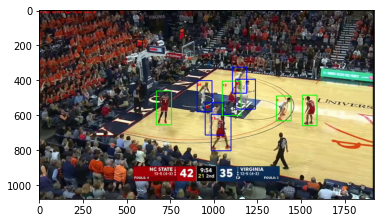

In [28]:
plt.imshow(frame)

colorado - black forma
washington - white form



GROUND TRUTH:
blue  - colorado - 0.0
green - washington - 1.0

PREDICTION:
0.0 - COLORADO
1.0 - WASHINGTON

RESULT:
    TRUE!

In [34]:
!aws s3 cp ./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4 s3://boost-operators-data/tracking_results/

upload: demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4 to s3://boost-operators-data/tracking_results/2020_01-20_NCState_at_Virginia.mp4


In [35]:
!rm ./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4